In [42]:
# 1️⃣ Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import joblib
from imblearn.over_sampling import SMOTE



In [43]:
# 2️⃣ Load dataset
file_path = r"C:\Users\User\Desktop\Credit Default Risk Prediction with Loan Approval Decision System\data\credit_default_clean.xlsx"
df = pd.read_excel(file_path)


In [44]:
# 3️⃣ Feature Engineering (only key features)
# Create credit utilization
df["CREDIT_UTILIZATION"] = df["BILL_AMT1"] / df["LIMIT_BAL"]
# Average payment delay
pay_delay_cols = ["PAY_0","PAY_2","PAY_3","PAY_4","PAY_5","PAY_6"]
df["AVG_PAY_DELAY"] = df[pay_delay_cols].mean(axis=1)
# Max payment delay
df["MAX_PAY_DELAY"] = df[pay_delay_cols].max(axis=1)


In [46]:
# 4️⃣ Select 8 key features
features = ["LIMIT_BAL","AGE","PAY_0","BILL_AMT1","PAY_AMT1",
            "CREDIT_UTILIZATION","AVG_PAY_DELAY","MAX_PAY_DELAY"]

X = df[features]
y = df["default"]  # target column


In [47]:
# 5️⃣ Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [48]:
# 6️⃣ Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Before SMOTE:\n", y_train.value_counts())
print("After SMOTE:\n", pd.Series(y_train_res).value_counts())


Before SMOTE:
 default
0    18691
1     5309
Name: count, dtype: int64
After SMOTE:
 default
0    18691
1    18691
Name: count, dtype: int64


In [49]:
# 7️⃣ Scale features
scaler = StandardScaler()
X_train_res_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

In [50]:
# 8️⃣ Hyperparameter tuning
param_grid = {
    "n_estimators": [200, 300],
    "max_depth": [10, 15, None],
    "min_samples_split": [2, 5],
    "class_weight": ["balanced"]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(
    rf, param_grid, cv=3, scoring="roc_auc", n_jobs=-1, verbose=1
)
grid_search.fit(X_train_res_scaled, y_train_res)

best_rf = grid_search.best_estimator_
print("Best Params:", grid_search.best_params_)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Params: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}


In [51]:
# 9️⃣ Predict with threshold
y_prob = best_rf.predict_proba(X_test_scaled)[:,1]
threshold = 0.3
y_pred = (y_prob >= threshold).astype(int)


Accuracy: 0.6885
Recall: 0.6465712132629993
Precision: 0.3799822852081488
F1-Score: 0.4786610878661088
ROC-AUC: 0.7404849904153654


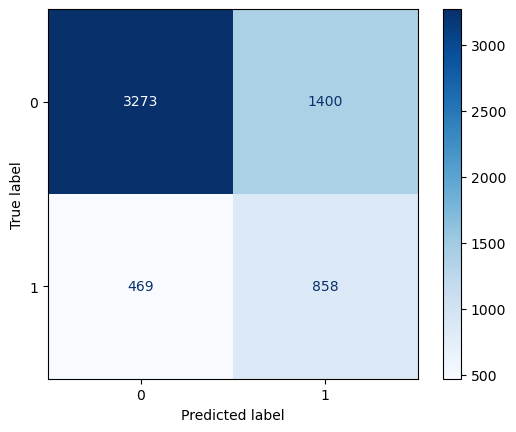

In [52]:
# 10️⃣ Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("F1-Score:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.show()

In [53]:
# 11️⃣ Save model and scaler
joblib.dump(best_rf, r"C:\Users\User\Desktop\Credit Default Risk Prediction with Loan Approval Decision System\model\credit_default_rf_8features.pkl")
joblib.dump(scaler, r"C:\Users\User\Desktop\Credit Default Risk Prediction with Loan Approval Decision System\model\scaler_8features.pkl")

print("Model and scaler saved successfully!")


Model and scaler saved successfully!
